---

Created for [learn-investments.rice-business.org](https://learn-investments.rice-business.org)
    
By [Kerry Back](https://kerryback.com) and [Kevin Crotty](https://kevin-crotty.com)
    
Jones Graduate School of Business, Rice University

---


# EXAMPLE DATA

In [49]:
# means
mn1 = 0.08
mn2 = 0.12
mn3 = 0.15

# std devs
sd1 = 0.15
sd2 = 0.25
sd3 = 0.35

# correlations
c12 = 0.15
c13 = 0.60
c23 = 0.30

# risk-free rate
rf = 0.02

# CREATE ARRAYS

In [50]:
import numpy as np

mn = np.array([mn1, mn2, mn3])
sd = np.array([sd1, sd2, sd3])

corr = np.identity(3)
corr[0, 1] = corr[1, 0] = c12
corr[0, 2] = corr[2, 0] = c13
corr[1, 2] = corr[2, 1] = c23

cov = np.diag(sd) @ corr @ np.diag(sd)

# CHECK CORRELATIONS

In [51]:
if np.all(np.linalg.eigvals(cov) > 0):
    print("correlations are acceptable")
else:
    print("correlations are inconsistent")

correlations are acceptable


# CALCULATE FRONTIER OF RISKY ASSETS

In [52]:
# global minimum variance portfolio
w = np.linalg.solve(cov, np.ones(3))
gmv = w / np.sum(w)
gmv_mn = gmv @ mn
gmv_sd = np.sqrt(gmv @ cov @ gmv)

# second frontier portfolio
w = np.linalg.solve(cov, mn)
second_port = w / np.sum(w)
second_mn = second_port @ mn
second_sd = np.sqrt(second_port @ cov @ second_port)

# means to display
min_mn = -0.1
max_mn = 1.5*np.max(mn)
mns = np.linspace(min_mn, max_mn, 101)

# portfolio weights and risks
gmv_wt = (mns - second_mn) / (gmv_mn - second_mn)
second_wt = 1 - gmv_wt
ports = (
    gmv_wt.reshape(-1, 1) * gmv.reshape(1, -1) +
    second_wt.reshape(-1, 1) * second_port.reshape(1, -1)
)
vr = np.diag(ports @ cov @ ports.T)
sds = np.sqrt(vr)


# CALCULATE TANGENCY PORTFOLIO

In [53]:
if gmv_mn < rf:
    print(
        """
        Figure will be incorrect.  For these parameter values, all
        efficient portfolios involve shorting risky assets and investing
        more than 100% at the savings rate.
        """
    )

In [54]:
tang = np.linalg.solve(cov, mn-rf)
tang = tang / np.sum(tang)
tang_mn = tang @ mn
tang_sd = np.sqrt(tang @ cov @ tang)

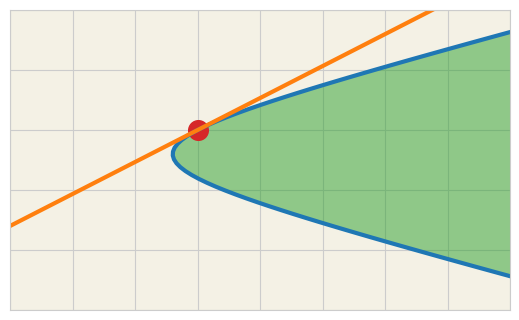

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid", {'axes.facecolor': '#f4f1e5'})
colors = sns.color_palette()
# Set the figure size to (5, 3) inches
plt.figure(figsize=(5, 3))

plt.plot(sds, mns, lw=3)

# Fill the area to the right of the efficient frontier curve
plt.fill_betweenx(mns, sds, max(sds)*1.2, alpha=0.5, color=colors[2])

# Set font sizes to 14pt for all labels


# Add labels and title
plt.xlabel('')
plt.ylabel('')

# Remove tick labels
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Set x-axis limit to ensure the filled area is visible
plt.xlim(0, 0.4)
plt.ylim(-0.05, 0.2)

plt.scatter([tang_sd], [tang_mn], s=200, color=colors[3])
plt.plot([0, 0.4], [rf, rf+0.4*(tang_mn-rf)/tang_sd], color=colors[1], lw=3)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("../posts/07-mean-variance/tangency.png")




# FIGURE

In [65]:
import plotly.graph_objects as go
import plotly.io as pio
plotly_template = pio.templates["simple_white"]
colors = plotly_template.layout.colorway

# frontier of risky assets
string = 'asset 1: %{customdata[0]:.0%}<br>'
string += 'asset 2: %{customdata[1]:.0%}<br>'
string += 'asset 3: %{customdata[2]:.0%}<br>'
string += '<extra></extra>'
trace1 = go.Scatter(
    x=sds,
    y=mns,
    mode="lines",
    customdata=ports,
    hovertemplate=string
)

# tangency portfolio
string = "tangency portfolio<br>"
string += 'asset 1: %{customdata[0]:.0%}<br>'
string += 'asset 2: %{customdata[1]:.0%}<br>'
string += 'asset 3: %{customdata[2]:.0%}<br>'
string += '<extra></extra>'
trace3 = go.Scatter(
    x=[tang_sd],
    y=[tang_mn],
    customdata=tang.reshape(1, -1),
    hovertemplate=string,
    mode="markers",
    marker=dict(size=15)
)

# frontier including risk-free asset
ports = np.arange(0, 4.01, 0.01).reshape(-1, 1) * tang.reshape(1, -1)
x = np.sqrt(np.diag(ports @ cov @ ports.T))
y = rf + ports @ (mn-rf)
string = 'asset 1: %{customdata[0]:.0%}<br>'
string += 'asset 2: %{customdata[1]:.0%}<br>'
string += 'asset 3: %{customdata[2]:.0%}<br>'
string += '<extra></extra>'
trace4 = go.Scatter(
    x=x,
    y=y,
    mode="lines",
    customdata=ports,
    hovertemplate=string,
    line=dict(color=colors[5])
)

fig = go.Figure()
for trace in (trace1, trace3, trace4):
    fig.add_trace(trace)
# Create a filled area between the lower and upper arms of the hyperbola
# First, we need to separate the upper and lower parts of the frontier
# Sort the points by standard deviation
sort_idx = np.argsort(sds)
sorted_sds = sds[sort_idx]
sorted_mns = mns[sort_idx]
sorted_ports = ports[sort_idx]

# Find the minimum variance portfolio (lowest x value)
min_var_idx = np.argmin(sorted_sds)
lower_sds = sorted_sds[:min_var_idx+1]
lower_mns = sorted_mns[:min_var_idx+1]
upper_sds = sorted_sds[min_var_idx:]
upper_mns = sorted_mns[min_var_idx:]

# Create a filled area between the upper and lower arms
fill_x = np.concatenate([upper_sds, lower_sds[::-1]])
fill_y = np.concatenate([upper_mns, lower_mns[::-1]])

# Add the filled area
fig.add_trace(go.Scatter(
    x=fill_x,
    y=fill_y,
    fill='toself',
    fillcolor='rgba(0, 0, 255, 0.1)',
    line=dict(color='rgba(0, 0, 255, 0)'),
    hoverinfo='skip',
    showlegend=False
))

# Set the figure size to 7 x 5 inches
fig.update_layout(
    width=420,  # 7 inches * 100 pixels per inch
    height=300,  # 5 inches * 100 pixels per inch
    margin=dict(l=50, r=50, t=50, b=50),  # Add margins to ensure labels are visible
)

# Set the upper x limit to 50%
fig.update_xaxes(range=[0, 0.5])

# Add a background shade to the border of the figure


# Style the axis lines to stand out against the background
fig.update_xaxes(
    showline=True,
    linewidth=2,
    linecolor='rgba(0, 0, 0, 0.3)',
    gridcolor='rgba(200, 200, 200, 0.2)'
)

# Make the plot lines thicker
fig.update_traces(
    line=dict(width=5),  # Increase line thickness
    selector=dict(type='scatter', mode='lines')
)

# Make axis labels boldface
fig.update_layout(
    xaxis_title=dict(
        text="Standard Deviation",
        font=dict(
            family="Arial, sans-serif",
            size=18,
            color="#000000",
            weight="bold"
        )
    ),
    yaxis_title=dict(
        text="Expected Return",
        font=dict(
            family="Arial, sans-serif",
            size=18,
            color="#000000",
            weight="bold"
        )
    )
)


fig.update_yaxes(
    showline=True,
    linewidth=2,
    linecolor='rgba(0, 0, 0, 0.3)',
    gridcolor='rgba(200, 200, 200, 0.2)'
)


fig.update_layout(
    xaxis_rangemode="tozero",
    yaxis_rangemode="tozero",
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    template="plotly_white",
    showlegend=False
)

fig.update_layout(
    plot_bgcolor='white',  # Keep the plot area white
    margin=dict(l=60, r=60, t=30, b=60),  # Slightly increase margins to show more of the background
)


# Set a light red paper background color
fig.update_layout(
    paper_bgcolor='rgba(255, 235, 235, 0.5)',  # Light red background with some transparency
)



# Lighten grid lines further
fig.update_xaxes(
    gridcolor='rgba(220, 220, 220, 0.1)'  # Lighter grid lines
)

fig.update_yaxes(
    gridcolor='rgba(220, 220, 220, 0.1)'  # Lighter grid lines
)

# Make axis lines more visible against lighter background
fig.update_xaxes(
    linecolor='rgba(0, 0, 0, 0.5)'  # Darker axis lines
)

fig.update_yaxes(
    linecolor='rgba(0, 0, 0, 0.5)'  # Darker axis lines
)


# Set a pleasing color scheme with complementary colors
# Light blue for the plot area and soft peach for the border
fig.update_layout(
    plot_bgcolor='rgba(235, 245, 255, 0.7)',  # Light blue for plot area
    paper_bgcolor='rgba(255, 240, 230, 0.8)',  # Soft peach for border
)

# Adjust grid and axis lines to be visible against the new background
fig.update_xaxes(
    gridcolor='rgba(180, 180, 200, 0.2)',  # Subtle grid lines that work with blue background
    linecolor='rgba(0, 0, 0, 0.4)'  # Darker axis lines for contrast
)

fig.update_yaxes(
    gridcolor='rgba(180, 180, 200, 0.2)',  # Subtle grid lines that work with blue background
    linecolor='rgba(0, 0, 0, 0.4)'  # Darker axis lines for contrast
)
# Remove modebar (the icons at the top of the plot)

# Fix the modebar display issue by using the correct property
# The 'modebar_display' property doesn't exist - we need to use 'displayModeBar' instead

# Fix the modebar display issue by using the correct property
# The displayModeBar property is not valid for plotly.graph_objs.Layout
# Instead, we need to use the config parameter when calling fig.show()

# Remove the incorrect property
fig.update_layout(
    # Remove specific buttons from the modebar
    modebar_remove=['zoom', 'pan', 'select', 'zoomIn', 'zoomOut', 'autoScale', 'resetScale', 
                    'toImage', 'sendDataToCloud', 'toggleSpikelines', 
                    'hoverClosestCartesian', 'hoverCompareCartesian']
)

# We'll set the displayModeBar option in the config parameter of fig.show() below
# This is the correct way to hide the modebar in Plotly


fig.show()